In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


# 1) Libraries Used

In [2]:
import pandas as pd # for operations on csv
import numpy as np # Just love to import this, comes handy sometimes
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
from sklearn.feature_extraction.text import CountVectorizer #To convert to BOW representation
from sklearn.feature_extraction.text import TfidfVectorizer #To convert to Tf-IDF representation
from nltk.corpus import stopwords #used to remove words in NLP which does not provide contextual information like ('will','is') etc.
from wordcloud import WordCloud # for printing wordcloud
from nltk.stem.snowball import SnowballStemmer # for getting the root of the words
from sklearn.model_selection import train_test_split# for separating data into test/train,this way it is faster and more efficient
from sklearn.multiclass import OneVsRestClassifier# used for multi label classification
import re # used for filtering regular expressions
from nltk.tokenize import word_tokenize # used to convert words into tokens,equal to lamba x:x.split()
from sklearn.linear_model import SGDClassifier #ML Model
from sklearn.linear_model import LogisticRegression# ML Model
from sklearn import metrics # Metrics used for evaluating model
from sklearn.metrics import f1_score,precision_score,recall_score # Metrics used for evaluating model
from sklearn.feature_extraction.text import TfidfVectorizer # Create a TF-IDF vector
from bs4 import BeautifulSoup # used here for Removing Http tags like <b>
from datetime import datetime # used to calculate time running a block
from scipy.sparse import hstack # used to add dense array to sparse matrix for train both of them together


# 2) Train Data Overview 

In [3]:
data = pd.read_csv('/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip')

In [6]:
print('Total Rows: {}\nTotal Columns: {}'.format(data.shape[0],data.shape[1]))
print('Columns: ',data.columns[0],data.columns[1],data.columns[2],data.columns[3])
print('Size of Train.zip in GB \'{}\' '.format(os.path.getsize('/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip')/10**9))


Total Rows: 6034195
Total Columns: 4
Columns:  Id Title Body Tags
Size of Train.zip in GB '2.347110159' 


In [7]:
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [8]:
print('ML Problem: We need to predict Tags from Title and Body, also we have multiple tags to predict for a single data point, this is a multi-label Classification problem')
print('\n\nRefer: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/  to understand how to solve multi label classification')

ML Problem: We need to predict Tags from Title and Body, also we have multiple tags to predict for a single data point, this is a multi-label Classification problem


Refer: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/  to understand how to solve multi label classification


# 3) Performance metric Used
* Hamming Loss(Used in multi-label classification):https://www.kaggle.com/wiki/HammingLoss 
* Micro F1 Score(Used in multi label classification):https://www.kaggle.com/wiki/MeanFScore 
* Macro F1 Score(Used in multi label classification):https://www.kaggle.com/wiki/MeanFScore 

# 4) Exploratory Data Analysis
I will take less data to perform EDA and also to solve ML problem, as I don't have much computational power available on kaggle

In [9]:
data = data.iloc[:10000,:]
print(data.shape)
print(data.columns)

(10000, 4)
Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')


4.1) Checking for Duplicates

In [20]:
data_copy = data.copy()
duplicates = data_copy.duplicated(['Body','Tags'])
print('Total Duplicates:',duplicates.sum())
print('-'*50,'Removing Duplicates','-'*50)

data_copy = data_copy[~duplicates]

print('Shape of Data Frame Now',data_copy.shape)
print('-'*30,'Checking for any More Duplicates','-'*30)
print('Any More Duplicated data ', data_copy.duplicated(subset=['Title','Tags']).sum())
print('-'*30,'Analysing the Duplicated Data','-'*30)


print('\nStill Duplicated ID:')
#print( data_copy[data_copy['Title'] == data_copy['Title']]['Tags'])
print(data_copy[data_copy.duplicated(subset=['Title','Tags'])]['Id'])
print('----'*70)
print(data_copy[data_copy['Id']==3081]['Body'])
print('----'*70)
print(data_copy[data_copy['Id']==3082]['Body'])
print('----'*70)



Total Duplicates: 3
-------------------------------------------------- Removing Duplicates --------------------------------------------------
Shape of Data Frame Now (9997, 4)
------------------------------ Checking for any More Duplicates ------------------------------
Any More Duplicated data  1
------------------------------ Analysing the Duplicated Data ------------------------------

Still Duplicated ID:
3081    3082
Name: Id, dtype: int64
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3080    <p>How can I prevent a script from executing i...
Name: Body, dtype: object
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
print('Body and tags are completely different, so no further duplictes')

print(data_copy.shape)

Body and tags are completely different, so no further duplictes
(9997, 4)


4.2) Analysis of Tags

In [22]:
##Creating new column for tags count
data_copy['Tag_Count'] = data_copy['Tags'].apply(lambda x: len(x.split(' '))) 

Distribution of Tags per question:
 3    2919
2    2612
4    1969
1    1296
5    1201
Name: Tag_Count, dtype: int64


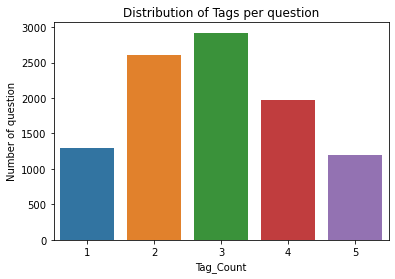

Average Distribution of Tags 2.9166750025007504


In [23]:
print('Distribution of Tags per question:\n',data_copy['Tag_Count'].value_counts() )
sns.countplot(data_copy['Tag_Count'])
plt.ylabel('Number of question')
plt.title('Distribution of Tags per question')
plt.show()
print('Average Distribution of Tags',data_copy['Tag_Count'].sum()/len(data_copy['Tag_Count']))

Observation
* Average Distribution of Tags 2.888603462577935
* 3 and 2 count of Tags dominate the dataset


In [24]:
##Converting Tags to BOW representation
vectorizer = CountVectorizer() #Default tokenizer = lamba x:x.split()
tag_data = vectorizer.fit_transform(data_copy['Tags'])
print('Sparse Matrix BOW Rows/Total Data Points:',tag_data.shape[0])
print('Sparse Matrix BOW Columns/Total Uniqe Tags:',tag_data.shape[1])

Sparse Matrix BOW Rows/Total Data Points: 9997
Sparse Matrix BOW Columns/Total Uniqe Tags: 4917


In [25]:
##Used to get the column/feature information from sparse matrix.
tag = vectorizer.get_feature_names()

In [26]:
## https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
frequency = tag_data.sum(axis=0)
frequency = np.array(frequency)

temp = zip(tag,frequency[0])
tag_count = dict(temp)

key =[]
value=[]
for keys,values in tag_count.items():
    key.append(keys)
    value.append(values)

tag_count_dataframe = pd.DataFrame(key)
tag_count_dataframe['Count'] = value
tag_count_dataframe = tag_count_dataframe.rename(columns ={0:'Tag'})
tag_count_dataframe['TAG ID'] = tag_count_dataframe.index +1

In [27]:
tag_count_dataframe = tag_count_dataframe.sort_values(['Count'],ascending='False')

In [28]:
tag_count_dataframe.shape

(4917, 3)

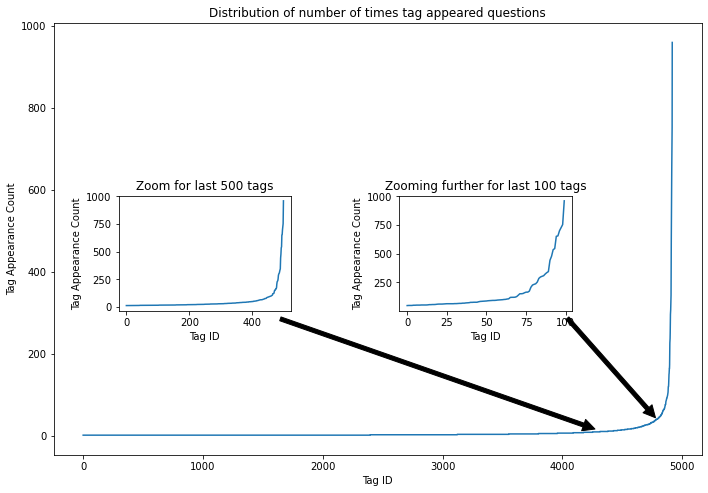

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.plot(tag_count_dataframe['Count'].values)
ax.set_ylabel('Tag Appearance Count')
ax.set_xlabel('Tag ID')
ax.set_title("Distribution of number of times tag appeared questions")

ax2 = fig.add_axes([0.15,0.5,.4,.4])
ax2.plot(tag_count_dataframe['Count'].values[4417:4917])
ax2.set_ylabel('Tag Appearance Count')
ax2.set_xlabel('Tag ID')
ax2.set_title("Zoom for last 500 tags")

ax3 = fig.add_axes([0.8,0.5,.4,.4])
ax3.plot(tag_count_dataframe['Count'].values[4817:4917])
ax3.set_ylabel('Tag Appearance Count')
ax3.set_xlabel('Tag ID')
ax3.set_title("Zooming further for last 100 tags")
ax.annotate('', xy=(4417, 1), xytext=(1500, 300),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax.annotate('', xy=(4817, 30), xytext=(4000, 300),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
fig.show()


In [37]:
print('I will take limited amount of tags, as with increase of each tag I will have to train one extra model, which is computationlly expensive for me')


I will take limited amount of tags, as with increase of each tag I will have to train one extra model, which is computationlly expensive for me


4.3) Fancy Wordcloud

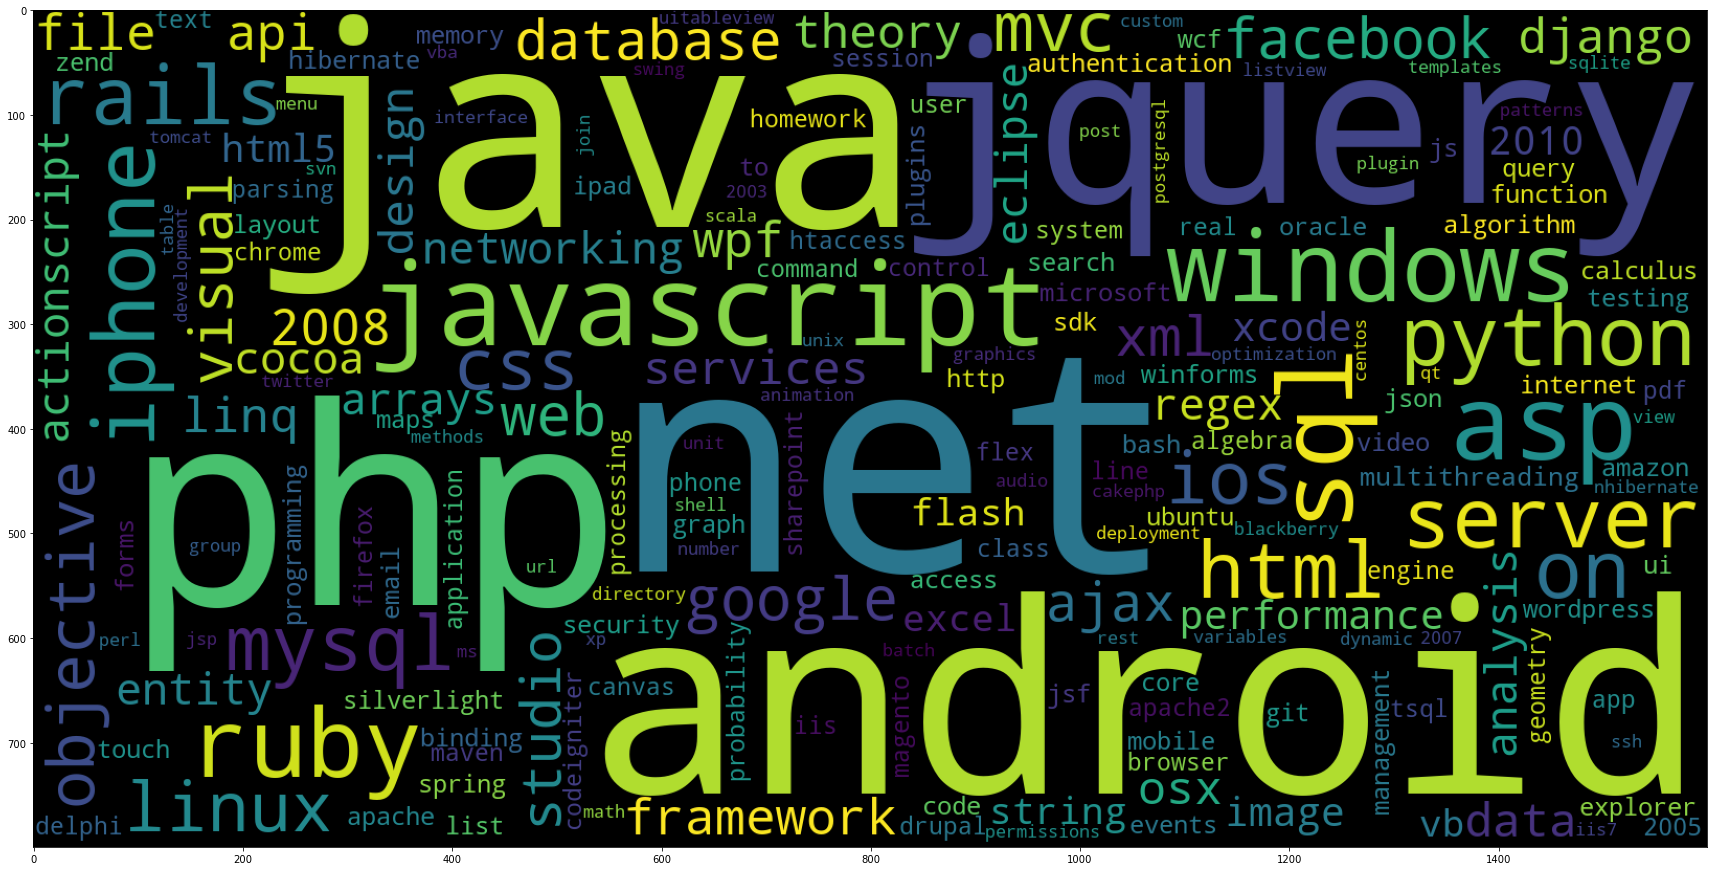

In [38]:
wordcloud = WordCloud(background_color='black',width=1600,height=800).generate_from_frequencies(tag_count)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)

4.4) Top 20 Tags

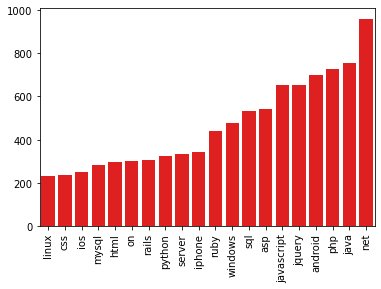

In [39]:
sns.barplot(tag_count_dataframe['Tag'].values[4897:4917],tag_count_dataframe['Count'].values[4897:4917],color='red')
plt.xticks(rotation=90)
plt.show()

Observation
* net,Java and PHP are most popular tags

# 5) Pre-Processing

In [40]:
stop_words=set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [41]:
question_list  = []
question_with_code = [ ]
len_before_preprocessing = 0 
len_after_preprocessing = 0 
time_before=datetime.now()

data_copy = data_copy.drop(['Id'],axis=1)

for _,rows in data_copy.iterrows():
    title,body,tags = rows[0],rows[1],rows[2]
    if '<code>' in body:
        question_with_code.append(1)
    else:
        question_with_code.append(0)
    len_before_preprocessing += len(title) + len(body)
    body = re.sub('<code>(.*?)<code>', ' ', body, flags = re.DOTALL|re.MULTILINE)
    body = re.sub('<.*?>',' ',body)
    body = body.encode('utf-8')
    title = title.encode('utf-8')
    question = str(title) + ' ' + str(title) + ' ' + str(title) + ' ' + str(body)## Giving 3 times more importance to title
    question = re.sub(r'[^A-Za-z]+',' ',question) # removes punctuation marks or special characters
    question = re.sub(r'http\S+',' ',question) # removes all http tags
    soup = BeautifulSoup(question, 'lxml') # removes all xml tags
    question = soup.get_text()
    words=word_tokenize(str(question.lower()))
    question = ' '.join(str(stemmer.stem(i)) for i in words if i not in stop_words and (len(i)>1 or i=='c'))
    question_list.append(question)
    len_after_preprocessing += len(question)
data_copy['question'] = question_list
data_copy['code_exist'] = question_with_code
time_after = datetime.now()
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/data_copy.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/data_copy.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (sum(question_with_code)*100.0)/data_copy.shape[0])
print('Time taken to run this cell',time_after-time_before)
    
    

Avg. length of questions(Title+Body) before preprocessing:  1158.5306591977594
Avg. length of questions(Title+Body) after preprocessing:  577.9235770731219
% of questions containing code:  55.886766029808946
Time taken to run this cell 0:00:27.426625


In [42]:
preprocessed_df = data_copy.drop(['Title','Body','Tag_Count'],axis=1)
preprocessed_df.to_csv('Preprocessed_data_Stackoverflow.csv')
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (9997, 3)


In [44]:
os.listdir()

['__notebook_source__.ipynb', 'Preprocessed_data_Stackoverflow.csv']

# 6) Machine Learning problem

6.1) Creating Multilabels

In [61]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true') # binary=True--> One hot Enoding without removing first column in this case
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags'])

In [62]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [63]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

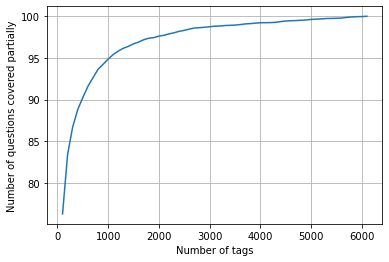

94.848 % of questions covered by 1000 tags
Number of questions that are not covered by 100 tags :  515 out of  9997


In [64]:
plt.plot(np.arange(100,total_tags, 100),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[9],"% of questions covered by 1000 tags")
print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(1000),"out of ", total_qus)

In [65]:
yx_multilabel = tags_to_consider(1000)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 6124
Number of tags considered : 1000 ( 16.32919660352711 %)


7.2) SPlitting into test and train

In [66]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 7997
Number of data points in test data : 2000


In [67]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [68]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (7997, 200000) Y : (7997, 1000)
Test data shape X :  (2000, 200000) Y: (2000, 1000)


7.3) Fitting logistic and One vs Rest classifier and adding 'code_exist' column to my train and test data

In [69]:
from scipy.sparse import hstack ## Adding code_exist column to my training data
X_train_multilabel = hstack((X_train_multilabel,np.array(X_train['code_exist'])[:,None]))
X_test_multilabel = hstack((X_test_multilabel,np.array(X_test['code_exist'])[:,None]))

In [70]:
time_before=datetime.now()

clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)
time_after = datetime.now()
print('Time taken to run this cell',time_after-time_before)


Time taken to run this cell 0:02:26.602721


In [71]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.1445
Macro f1 score : 0.1588180021386571
Micro f1 scoore : 0.4317180616740088
Hamming loss : 0.0018705


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,Tags,question,code_exist
0,php image-processing file-upload upload mime-t...,check upload file imag without mime type check...,0
1,firefox,prevent firefox close press ctrl prevent firef...,0
2,r matlab machine-learning,error invalid type list variabl error invalid ...,1
3,c# url encoding,replac special charact url replac special char...,0
4,php api file-get-contents,modifi whoi contact detail modifi whoi contact...,1
...,...,...,...
9995,sip asterisk,asterisk sip found asterisk sip found asterisk...,1
9996,java jsf jsf-2.0 facelets nullpointerexception,stop el express evalu non render jsf compon st...,1
9997,java jsp servlets,java lang illegalstateexcept forward respons c...,1
9998,haskell,forward data vector permut function forward da...,1
